# <i>Demonstrating the utility of pagerank-index using synthesized systems of scientists</i>

In [1]:
!pip install ipynb
from ipynb.fs.full.utility import *

In [2]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

<b>Scenarios:</b>
<ol>
  <li><i><b>MANIPULATIVE authors:</b> when authors try to ‘massage’ their index by publishing papers in low-quality outlets primarily to self-cite other papers</i> </li>
  <li><i><b>COLLABORATIVE authors:</b> when authors collaborate in large groups in order to obtain more authorships </i></li>
  <li><i><b>QUANTITY_ORIENTED authors:</b> when authors spend most of their time in producing genuine but low quality publications that would massage their index</i></li>

</ol>

In [3]:
from enum import Enum
class Scenario(Enum):
    MANIPULATIVE = 1
    COLLABORATIVE = 2
    QUANTITY_ORIENTED = 3

<i>
The system simulates the evolution of a field in the following manner. At the beginning of
the simulation, a sequence of papers are ‘spawned’ and a certain number of authors $N_a$ are
spawned and assigned to each paper. 
</i>
<ul>
    <li><i>The number of authors $N_a$ is a random number between <b>2–5</b>. </i>
    <li><i> Each spawned paper is also randomly assigned <b>an impact factor</b> between <b>0–20</b>. (For simplicity, in this initial study we keep the distribution of impact factors linear, though clearly it is biased towards lower values.)</i>
    <li><i> When papers after the first paper are spawned, a certain number $N_a^{*} \leq N_a$ of authors are randomly
selected and assigned from the existing author pool, while the rest  $N_a - N_a^{*}$ authors are newly spawned. (This represents new authors being introduced to the field as ‘collaborators’ of existing
authors, as it typically happens. <b>The probability of new authors being spawned</b> decreases as the
simulation progresses, so that authors are increasingly assigned from existing author pool. At
steady state, the probability of an author being a new author rather than somebody from the
existing author pool was fixed at <b>4%</b>.)</i>
    <li><i> Each spawned paper is randomly assigned a number $N_r$ <b>between 10 and 50</b> to represent <b>the length of its reference list</b>, since 10–50 references are typical for most scientific papers.</i>
    <li><i> However, not all of these references are necessarily to existing papers
in the simulated system. In real world, a paper which is a pioneer in a new field will by necessity
refer to papers ‘outside’ its field, since there are no papers already in the emerging field to cite.
Even in a saturated field, a certain proportion of the references will be outside the field anyway.
To reflect this, we set proportion $ψ$ as <b>the proportion of references which are within the ‘field’</b>,
and this proportion <b>begins with zero</b> and increases linearly with each paper until it reaches the
steady-state value of <b>70%</b>. Thus, the number of ‘citations’ by each paper to other existing papers
within the field is $ψN_r$.</i>
    <li><i> Once the number of internal references is determined, existing paper objects are chosen to be the references in the newly spawned paper. The references by newly spawned papers to the pool of existing papers were made by using
the well-known <b>‘preferential attachment’</b> method. A weighted preferential attachment scheme
was used, so that existing papers <b>have a higher chance of being cited by newly spawned papers
if they had already a high number of citations or published in a journal of high impact factor</b>. It
was ensured that papers which were never cited or published in an outlet of zero impact factor
could still be cited, albeit with a very small probability. </i><br>
         <b>NOTE:</b> In my implementation the chance of being cited depends only on the impact factor but not on the current number of citations.
    
</ul>
<i>
Eventually, a directed citation network begin to evolve. We continue this process for a fixed number of ‘timesteps’. Timesteps have no meaning in terms of physical time but simply denote an instance where a new paper is spawned.

</i>


In [4]:
def simulate(database, N_papers, scenario, negative_paper_probability=None, negative_author_probability=None, seed=7):
    random.seed(seed)

    # parameters
    new_author_probability = 1
    Psi = 0
    if scenario == Scenario.MANIPULATIVE: 
        negative_paper_probability = 0.3
        negative_author_probability = 0.2
    elif scenario == Scenario.COLLABORATIVE: 
        negative_paper_probability = 0.8
        negative_author_probability = 0.9
    elif scenario == Scenario.QUANTITY_ORIENTED:
        negative_paper_probability = 0.1
        negative_author_probability = 0.1
        
    # spawn N_papers papers
    for paper_id in range(N_papers):

        # "negative" paper or not
        alpha = random.random()
        member = alpha < negative_paper_probability

        # num_of_authors
        if scenario == Scenario.COLLABORATIVE:
            if member:
                num_of_authors = random.randint(1, 10)
            else:
                num_of_authors = random.randint(1, 4)
        else:
            num_of_authors = random.randint(2, 6)

        # generate author list
        author_list = []
        for _ in range(num_of_authors):
            # set member attribute for an author
            if scenario == Scenario.MANIPULATIVE or scenario == Scenario.QUANTITY_ORIENTED:
                if member:
                    new_author_member = member
                else:
                    beta = random.random()
                    new_author_member = beta < negative_author_probability
                positive_case_authors = database.all_authors
            elif scenario == Scenario.COLLABORATIVE:
                new_author_member = member
                positive_case_authors = database.positive_authors

            # choose an author
            alpha = random.random()
            if alpha < new_author_probability:
                author = Author(database, database.new_author_id(), new_author_member)
            else:
                if member and database.negative_authors:
                    old_author = random.choice(database.negative_authors)
                elif (not member) and positive_case_authors:
                    old_author = random.choice(positive_case_authors)
                else:
                    old_author = None
                        
                if (old_author == None) or (old_author in author_list):
                    author = Author(database, database.new_author_id(), new_author_member)
                else:
                    author = old_author
                
            author_list.append(author)

        if new_author_probability > 0.04:
            new_author_probability *= 0.9
        if new_author_probability < 0.04:
            new_author_probability = 0.04

        # impact_factor
        if (scenario == Scenario.MANIPULATIVE or scenario == Scenario.QUANTITY_ORIENTED) and member:
            impact_factor = random.randint(0, 1)
        else:
            impact_factor = random.randint(0, 21)

        num_of_refs = random.randint(10, 51)
        num_of_inter_refs = int(Psi * num_of_refs)
        Psi = Psi + 0.1 if Psi + 0.1 < 0.7 else 0.7

        # citing
        if scenario == Scenario.MANIPULATIVE and member:
            papers_to_cite = []
            for author in author_list:
                for paper in author.paper_list:
                    if not paper.member:
                        papers_to_cite.append(paper)
        else:
            papers_to_cite = database.all_papers

    
        impact_factors = [paper.impact_factor for paper in papers_to_cite]
        s = sum(impact_factors)
        if s == 0:
            probabilities = impact_factors
        else:
            probabilities = [f/s for f in impact_factors]
        

        non_zero_probabilities = 0
        for p in probabilities:
            if not p == 0:
                non_zero_probabilities += 1
        num_of_inter_refs = min(num_of_inter_refs, non_zero_probabilities)


        if num_of_inter_refs > 0:
            inter_refs = random.choice(a=papers_to_cite, p=probabilities, size=num_of_inter_refs, replace=False)
        else:
            inter_refs = []


        for ref in inter_refs:
            database.add_citation((paper_id, ref.paper_id))

        Paper(database, paper_id, member, author_list, impact_factor, num_of_refs, num_of_inter_refs)

## Simulate the evolution of citation networks

#### Simulate the evolution of network with the existence of <i>MANIPULATIVE</i> scientists

In [5]:
N_papers = 10000
db_man = CitationDatabase()
simulate(db_man, N_papers=N_papers, scenario=Scenario.MANIPULATIVE)

#### Simulate the evolution of network with the existence of <i>COLLABORATIVE</i> scientists

In [6]:
N_papers = 10000
db_coll = CitationDatabase()
simulate(db_coll, N_papers=N_papers, scenario=Scenario.COLLABORATIVE)

#### Simulate the evolution of network with the existence of <i>QUANTITY-ORIENTED</i> scientists

In [7]:
N_papers = 10000
db_quant = CitationDatabase()
simulate(db_quant, N_papers=N_papers, scenario=Scenario.QUANTITY_ORIENTED)

## Calculate all necessary indices (rankings) based on citations from the database

In [8]:
db_man.ranking_update()

In [9]:
db_coll.ranking_update()

In [10]:
db_quant.ranking_update()

## Plot rankings

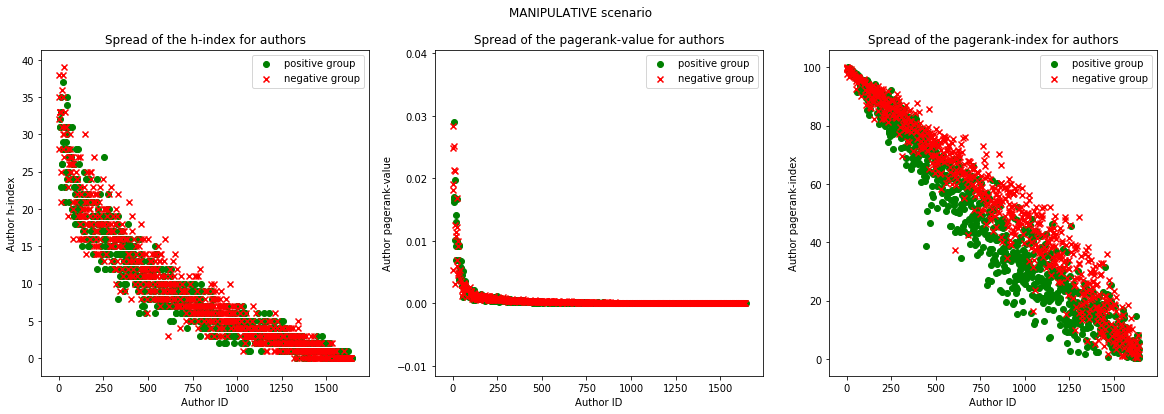

In [11]:
plot_indices(db_man, title="MANIPULATIVE scenario", 
             marker_pos='o', marker_neg='x')

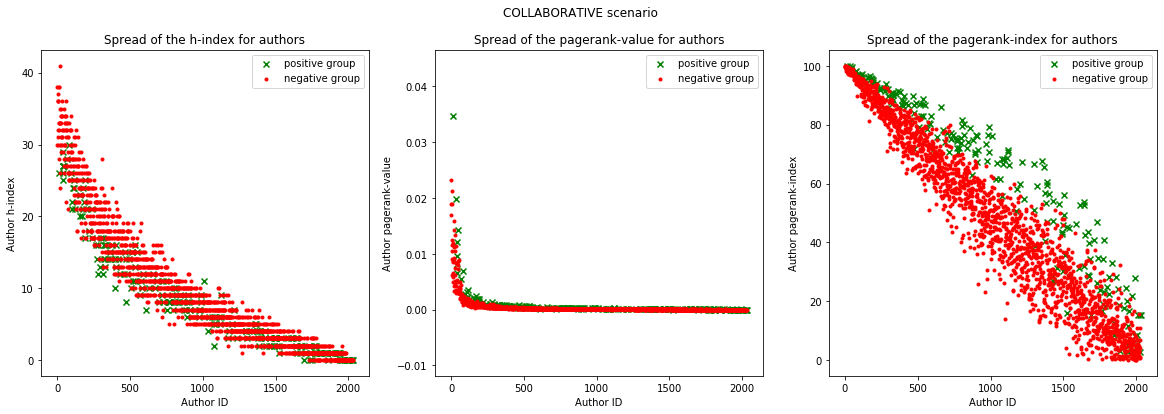

In [12]:
plot_indices(db_coll, title="COLLABORATIVE scenario", 
             marker_pos='x', marker_neg='.', color_pos='red', color_neg='green')

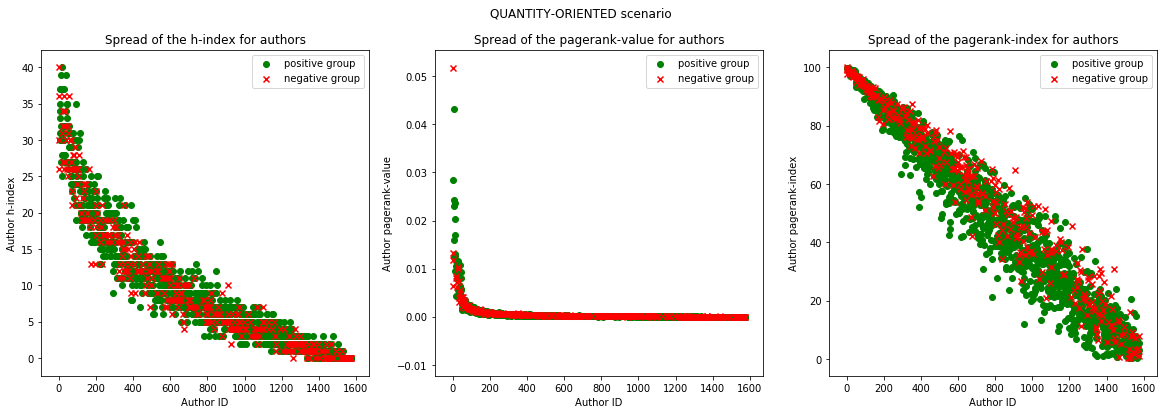

In [13]:
plot_indices(db_quant, title="QUANTITY-ORIENTED scenario")